In [63]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from lenet5 import LeNet

import numpy as np
# import pandas as pd
# import fedAvg
# from tqdm import tqdm # progress bar, not really necessary



In [64]:
# Set Parameters 

# Check if cuda is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Training Parameters 
EPOCHS = 10
LEARNING_RATE = 2e-3 
BATCH_SIZE = 32

# Parameters for Federated :earning
num_clients = 20 # number of total clients
num_selected = 6 # number of  clients selected for the training 
num_rounds = 10

In [65]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_target in train_loader:
        
        # set gradient to zero
        optimizer.zero_grad()

        # if there is a GPU

        X = X.to(device)
        y_target =y_target.to(device)

        # prediction

        # call model forward()
        y_predict, _ = model(X)
        # get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)
        
        # adjusting weights
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss
 
def test(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_target in valid_loader:
        # if there is a GPU

        X = X.to(device)
        y_target = y_target.to(device)

        # prediction and loss

        # call model forward()
        y_predict, _ = model(X)
        # get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss
 

def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n
 
def client_update(model, optimizer, train_loader,device,criterion ,epoch=5):
    """
    This function updates/trains client model on client data
    """
    # model.train()
    for e in range(epoch):
        model, optimizer, train_loss = train(train_loader, model,
                                criterion, optimizer, device)



        # for batch_idx, (data, target) in enumerate(train_loader):
        #     # data, target = data, target
        #     optimizer.zero_grad()
        #     output = model(data)
        #     loss = F.nll_loss(output, target) # The negative log likelihood loss
        #     loss.backward()
        #     optimizer.step()
    # return loss.item()
    #print(train_loss)
    return train_loss

def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
        # print(global_dict[k])
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

  

In [66]:
def training_loop(centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader,
                epochs, device, print_every=1):

    global_train_losses = [] # train_loss
    global_valid_losses = []

    global_train_accuracies = [] # train_accuracy
    global_valid_accuracies = []

    for round in range(num_rounds):

        # Select random clients
        # Select in the total number of clients, a random array of clients of size num_selected at each round
        client_idx = np.random.permutation(num_clients)[:num_selected]
    
        local_train_losses = [] # local_losses
        local_train_accuracies = []
        local_valid_losses = []
        local_valid_accuracies = []

        for i in range(num_selected):
            # Train federated model locally in client i for num epochs = EPOCHS
            local_train_loss = client_update(federatedModels[i], optimizers[i], train_loader[client_idx[i]],DEVICE,criterion, epoch=EPOCHS)
            local_train_acc = get_accuracy(federatedModels[i], train_loader[client_idx[i]], DEVICE)

            local_train_losses.append(local_train_loss)
            local_train_accuracies.append(local_train_acc)

            local_valid_loss = test(test_loader, federatedModels[i], criterion, DEVICE)[1]
            local_valid_acc = get_accuracy(federatedModels[i], test_loader, DEVICE)

            local_valid_losses.append(local_valid_loss)
            local_valid_accuracies.append(local_valid_acc)

        server_aggregate(centralizedModel, federatedModels)

        # Calculate avg training loss over all selected users at each round
        local_train_loss_avg = sum(local_train_losses) / len(local_train_losses)
        global_train_losses.append(local_train_loss_avg)

        # Calculate avg training accuracy over all selected users at each round 
        local_train_acc_avg = sum(local_train_accuracies) / len(local_train_accuracies)
        global_train_accuracies.append(local_train_acc_avg)


        # Calculate avg valid loss over all selected users at each round
        local_valid_loss_avg = sum(local_valid_losses) / len(local_valid_losses)
        global_valid_losses.append(local_valid_loss_avg)

        # Calculate avg valid accuracy over all selected users at each round 
        local_valid_acc_avg = sum(local_valid_accuracies) / len(local_valid_accuracies)
        global_valid_accuracies.append(local_valid_acc_avg)



        # valid_loss = test(test_loader,centralizedModel,criterion, DEVICE)[1] # Test global model on data
        #valid_acc = get_accuracy(centralizedModel, test_loader, DEVICE)
    
        #global_valid_losses.append(valid_loss)
        #global_valid_accuracies.append(valid_acc)

        #print('%d-th round' % r)
        # print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, test_acc))
        #print('average train loss %0.3g ' % (loss / num_selected))
        #print(test_loss)
        #print(type(test_loss))
        #print(' test loss %0.3g '%(test_loss))
        #print('test acc: %0.3f'% (test_acc))
        print(f'Round: {round}\t'
                f'Train loss: {local_train_loss_avg:.4f}\t'
                  f'Valid loss: {local_valid_loss_avg:.4f}\t'
                  f'Train accuracy: {100 * local_train_acc_avg:.2f}\t'
                  f'Valid accuracy: {100 * local_valid_acc_avg:.2f}')



        # train_acc = get_accuracy(model, train_loader, device)
        # test_acc = get_accuracy(model, test_loader, device)
        # DOES NOT GET THE ACCURACY, CHECK WITH THE FUNCITON FROM THE FEDERATED LEARNING AAND COMPARE WITH CENTRALISED MODEL
    
    return centralizedModel, federatedModels, optimizers, (global_train_losses, global_valid_losses), (global_train_accuracies, global_valid_accuracies)

In [67]:
# Loaders and Transformations

# Image augmentation 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



# Loading CIFAR10 using torchvision.datasets
traindata = datasets.CIFAR10('./data', train=True, download=False, 
                transform=transform_train)


# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] 
                    / num_clients) for _ in range(num_clients)])
                    
# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=BATCH_SIZE, shuffle=True) for x in traindata_split]


# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data', train=False, 
            transform=transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
            ), batch_size=BATCH_SIZE, shuffle=True)
          

In [68]:
# Model Selection
model = LeNet().to(DEVICE)
centralizedModel = model

# list of models, model per device SELECTED ( same model for each device in our case)
federatedModels =  [model for _ in range(num_selected)]

for models in federatedModels:
    models.load_state_dict(centralizedModel.state_dict())  # we initialize every model with the central


optimizers = [torch.optim.SGD(model.parameters(), lr=LEARNING_RATE) for model in federatedModels]
# NO CRITERION?
criterion = nn.CrossEntropyLoss()




In [69]:
# Training 
centralizedModel, federatedModels, optimizers, (train_losses, valid_losses), (train_accuracies, valid_accuracies) = training_loop(centralizedModel, federatedModels, criterion, optimizers, train_loader, test_loader, EPOCHS, DEVICE)

Round: 0	Train loss: 1.9401	Valid loss: 1.9280	Train accuracy: 28.65	Valid accuracy: 30.29
Round: 1	Train loss: 1.5700	Valid loss: 1.5567	Train accuracy: 41.21	Valid accuracy: 43.08
Round: 2	Train loss: 1.4178	Valid loss: 1.4140	Train accuracy: 47.71	Valid accuracy: 49.01
Round: 3	Train loss: 1.2711	Valid loss: 1.3295	Train accuracy: 50.65	Valid accuracy: 51.67
Round: 4	Train loss: 1.1606	Valid loss: 1.2513	Train accuracy: 54.10	Valid accuracy: 55.63
Round: 5	Train loss: 1.0752	Valid loss: 1.1308	Train accuracy: 59.30	Valid accuracy: 59.47
Round: 6	Train loss: 1.0116	Valid loss: 1.1326	Train accuracy: 59.07	Valid accuracy: 59.92
Round: 7	Train loss: 0.9579	Valid loss: 1.0848	Train accuracy: 61.39	Valid accuracy: 62.23
Round: 8	Train loss: 0.9119	Valid loss: 1.0614	Train accuracy: 63.43	Valid accuracy: 63.51
Round: 9	Train loss: 0.8600	Valid loss: 1.0021	Train accuracy: 65.89	Valid accuracy: 65.41


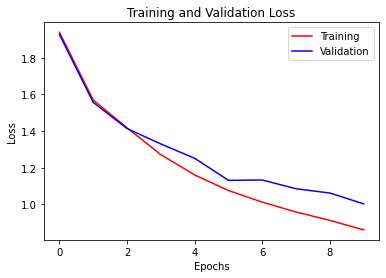

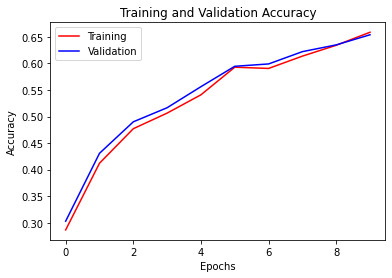

In [70]:
import matplotlib
import matplotlib.pyplot as plt

# Plotting Accuracy and Loss

SAVE_PLOTS = False# To save plots or show them
if SAVE_PLOTS:
    matplotlib.use("Agg") 

# Plot Loss 
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, color="r", label="Training")
plt.plot(range(len(valid_losses)), valid_losses, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Loss")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/centralised_LR[{}]_EPOCHS[{}]_loss.png".format(LEARNING_RATE, EPOCHS)) 
else:
    plt.show()

# Plot Accuracy
plt.figure()
plt.title("Training and Validation Accuracy")
plt.plot(range(len(train_accuracies)), train_accuracies, color="r", label="Training")
plt.plot(range(len(valid_accuracies)), valid_accuracies, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig("plots/centralised_LR[{}]_EPOCHS[{}]_accuracy.png".format(LEARNING_RATE, EPOCHS))
else:
    plt.show()